**Датасет:**

In [1]:
import pandas as pd
df = pd.read_csv('df.csv')
df.head()

,Unnamed: 0,id,fup,sex,dob,age,edu,diag,mmse,moca,...,pcount,ptotal,pmistake,prep,category,semantic,scount,stotal,smistake,srep
0,0,AAM113822A,0,f,01.05.1947,74.0,3,3.0,24.0,19.0,...,6.0,6.0,0.0,0.0,животные,"собака, лошадь, обезьяна, медведь, кошка, олен...",9.0,9.0,0.0,0.0
1,1,AAM113822A,1,f,01.05.1947,75.0,3,3.0,24.0,19.0,...,11.0,11.0,0.0,0.0,животные,"кошка, собака, тигр, волк, медведь, олень, лис...",11.0,11.0,0.0,2.0
2,2,ALV1945,0,f,27.05.1945,77.0,3,2.0,30.0,28.0,...,15.0,15.0,0.0,0.0,животные,"лев, тигр, лось, носорог, верблюд, корова, овц...",23.0,23.0,0.0,0.0
3,3,ARK517122A,0,f,11.10.1955,67.0,2,2.0,27.0,27.0,...,11.0,11.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,ATA224023A,0,f,04.08.1949,73.0,3,3.0,29.0,28.0,...,10.0,10.0,0.0,0.0,овощи,"картофель, редис, свекла, морковь, тыква, огур...",15.0,15.0,0.0,0.0


***Часть 1. Находим частотности слов относительно датасета***

In [2]:
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()
import nltk
#nltk.download('punkt_tab')
from nltk.probability import FreqDist

In [3]:
def get_relative_frequencies(answers_column): #принимает на вход колонку из датасета pandas
    #сохраняем все слова в отдельный список
    words = [line.lower().split(', ') for line in answers_column if line == line] #line == line убирает все NaN    
    wordlist = []
    for answer in words:
        for word in answer:
            if word != '?': #есть несколько слов, которые при сборе датасета расшифровать не удалось – они помечены ? и пока решили их игнорировать
                wordlist.append(word)
    #лемматизация – иногда у слова встречались и единственное, и множественное число – например, "банан" и "бананы"
    for word in range(len(wordlist)):
        wordlist[word] = morph.parse(wordlist[word])[0].normal_form 
    word_frequencies = FreqDist(wordlist) #создаем частотный словарь
    #собираем список частот – проходим по каждому слову в датасете и находим ему совпадение в частотном словаре
    frequencies = []
    for answer in answers_column:
        if answer == answer: #фильтрует NaN
            frequencies_list = []
            answer = answer.split(', ')
            for word in answer:
                if word != '?':
                    word = morph.parse(word)[0].normal_form
                    frequencies_list.append(round(word_frequencies[word]/len(wordlist) * 1000000, 2)) #relative frequency - items per million
            frequencies.append(frequencies_list)
        #else: frequencies.append('None')
        else: frequencies.append(np.nan)#сохранить пропуски, чтобы датасет не съехал
    return frequencies, word_frequencies #FreqDist понадобится потом

In [4]:
import statistics
import numpy as np #будем искать среднее значение
def get_average_frequency(frequencies): #принимает на вход результат прошлой функции. Эта функция подходит как для средней частотности относительно датасета, так и для частотности, взятой из словаря.
    frequencies_average = []
    for line in frequencies:
        try:
            frequencies_average.append(round(statistics.fmean(line),2))
        except:
            #frequencies_average.append('None')
            frequencies_average.append(np.nan)
    return frequencies_average

***Часть 2. Берём частоты из словаря Ляшевской и Шарова***

In [5]:
freq = pd.read_csv('freqrnc2011.csv', sep='\t')
freq.set_index('Lemma', inplace=True)
freq.head()

,PoS,Freq(ipm),R,D,Doc
Lemma,,,,,
а,conj,8198.0,100,97,32332
а,intj,19.8,99,90,757
а,part,6.1,59,79,128
а,s,2.7,59,85,160
аа,intj,1.5,47,80,68


In [6]:
def get_frequencies_fromdict(freq_dict, answers_column): #функция на вход принимает словарь частотностей и колонку ответов пациентов
    dictfrequencies = []
    for answer in answers_column:
        if answer == answer:
            frequencies_list = []
            answer = answer.split(', ')
            for word in answer:
                if word != '?':
                    word = morph.parse(word)[0].normal_form
                    try:                   
                        frequencies_list.append(round(freq_dict.loc[word]['Freq(ipm)'].item(),2))
                    except:
                        frequencies_list.append(0)
            dictfrequencies.append(frequencies_list)
        #else: dictfrequencies.append('None')
        else: dictfrequencies.append(np.nan)#сохранить пропуски, чтобы датасет не съехал
    return dictfrequencies

***Часть 3. Дополняем датасет***

In [7]:
#дополняем датасет: новые колонки – списки, возвращённые функциями
#сначала списки с результатами
df = df.assign(frequencies_phonetic = get_relative_frequencies(df['phonological'])[0],
            frequencies_semantic = get_relative_frequencies(df['semantic'])[0],            
            dict_frequencies_phonetic = get_frequencies_fromdict(freq, df['phonological']),       
            dict_frequencies_semantic = get_frequencies_fromdict(freq, df['semantic']))
            
#потом средние значения – если делать их вместе с прошлыми функциями, то выдает ошибку, поэтому отдельно
df = df.assign(average_frequency_phonetic = get_average_frequency(df['frequencies_phonetic']),
               average_frequency_semantic = get_average_frequency(df['frequencies_semantic']),
               dict_average_frequency_phonetic = get_average_frequency(df['dict_frequencies_phonetic']),
               dict_average_frequency_semantic = get_average_frequency(df['dict_frequencies_semantic']))

In [8]:
#выгружаем датасет
df.to_csv('frequencies.csv')
df.head()

,Unnamed: 0,id,fup,sex,dob,age,edu,diag,mmse,moca,...,smistake,srep,frequencies_phonetic,frequencies_semantic,dict_frequencies_phonetic,dict_frequencies_semantic,average_frequency_phonetic,average_frequency_semantic,dict_average_frequency_phonetic,dict_average_frequency_semantic
0,0,AAM113822A,0,f,01.05.1947,74.0,3,3.0,24.0,19.0,...,0.0,0.0,"[8601.55, 5826.86, 5826.86, 10266.37, 2219.76,...","[18670.65, 6348.02, 5601.19, 14563.11, 14563.1...","[127.6, 80.9, 35.9, 34.0, 1.3, 11.7]","[132.2, 80.9, 17.4, 33.4, 50.4, 15.6, 8.7, 11....",7260.45,10746.00,48.57,42.88
1,1,AAM113822A,1,f,01.05.1947,75.0,3,3.0,24.0,19.0,...,0.0,2.0,"[2497.23, 1942.29, 277.47, 1109.88, 277.47, 55...","[14563.11, 18670.65, 14189.69, 12696.04, 14563...","[50.4, 44.8, 5.3, 33.1, 12.2, 4.8, 85.0, 102.8...","[50.4, 132.2, 15.2, 36.1, 33.4, 15.6, 8.7, 6.5...",807.19,9505.06,43.23,30.51
2,2,ALV1945,0,f,27.05.1945,77.0,3,2.0,30.0,28.0,...,0.0,0.0,"[1664.82, 277.47, 5826.86, 11931.19, 9711.43, ...","[12322.63, 14189.69, 5974.61, 5974.61, 8588.5,...","[26.2, 52.2, 10.4, 323.9, 24.6, 78.7, 4.7, 18....","[64.3, 15.2, 6.5, 2.1, 11.2, 44.8, 17.5, 21.7,...",4975.95,6688.96,48.02,21.14
3,3,ARK517122A,0,f,11.10.1955,67.0,2,2.0,27.0,27.0,...,NaN,NaN,"[1109.88, 5271.92, 9711.43, 13873.47, 277.47, ...",NaN,"[29.0, 6.4, 2.9, 878.0, 6.7, 0, 0.5, 0.9, 12.7...",NaN,3430.53,NaN,85.45,NaN
4,4,ATA224023A,0,f,04.08.1949,73.0,3,3.0,29.0,28.0,...,0.0,0.0,"[6381.8, 2219.76, 4994.45, 10821.31, 1387.35, ...","[12696.04, 8588.5, 25392.08, 21284.54, 14563.1...","[64.3, 2.1, 9.9, 11.7, 3.5, 9.2, 11.8, 17.8, 0...","[12.3, 1.5, 0, 8.8, 5.0, 18.9, 15.4, 24.6, 2.6...",4883.46,15932.29,17.15,8.47


Получается 8 новых колонок: 4 для задания на букву (phonetic на конце), 4 для задания на категорию (semantic на конце).

***Часть 4. Частотные метрики***

Сначала для удобства поделим датасет на отдельные датафреймы по диагнозам

In [9]:
#сначала поделим на отдельные датафреймы по диагнозам 
norm = df[df['diag'] == 2] #"норма"
mci = df[df['diag'] == 3] #пациенты с синдромом мягкого когнитивного снижения, МКС (промежуточная стадия между нормой и деменцией)
dem = df[df['diag'] == 4] #пациенты с деменцией
norm.head() #проверяем, что остались только люди с нужным диагнозом

,Unnamed: 0,id,fup,sex,dob,age,edu,diag,mmse,moca,...,smistake,srep,frequencies_phonetic,frequencies_semantic,dict_frequencies_phonetic,dict_frequencies_semantic,average_frequency_phonetic,average_frequency_semantic,dict_average_frequency_phonetic,dict_average_frequency_semantic
2,2,ALV1945,0,f,27.05.1945,77.0,3,2.0,30.0,28.0,...,0.0,0.0,"[1664.82, 277.47, 5826.86, 11931.19, 9711.43, ...","[12322.63, 14189.69, 5974.61, 5974.61, 8588.5,...","[26.2, 52.2, 10.4, 323.9, 24.6, 78.7, 4.7, 18....","[64.3, 15.2, 6.5, 2.1, 11.2, 44.8, 17.5, 21.7,...",4975.95,6688.96,48.02,21.14
3,3,ARK517122A,0,f,11.10.1955,67.0,2,2.0,27.0,27.0,...,NaN,NaN,"[1109.88, 5271.92, 9711.43, 13873.47, 277.47, ...",NaN,"[29.0, 6.4, 2.9, 878.0, 6.7, 0, 0.5, 0.9, 12.7...",NaN,3430.53,NaN,85.45,NaN
24,24,BSV7823,0,m,11.01.1957,66.0,3,2.0,30.0,23.0,...,0.0,0.0,NaN,"[30246.45, 25392.08, 12696.04, 25018.67, 24645...",NaN,"[21.7, 0, 12.3, 18.9, 15.4, 1.5, 1.6]",NaN,19577.51,NaN,10.20
25,25,BZY546523,0,f,13.04.1955,68.0,3,2.0,NaN,26.0,...,0.0,0.0,"[6381.8, 7214.21, 6381.8, 8046.61, 2219.76, 33...","[18297.24, 24645.26, 25018.67, 21284.54, 28005...","[64.3, 0, 6.5, 11.8, 0.9, 16.7, 80.9, 11.7, 39...","[39.9, 15.4, 18.9, 8.8, 24.6, 2.6, 1.6, 21.7, 0]",4584.85,21699.44,17.78,14.83
26,26,CHGA042,1,m,03.08.1957,66.0,2,2.0,28.0,27.0,...,NaN,NaN,"[3052.16, 2219.76, 8046.61, 5826.86, 2219.76, ...",NaN,"[19.5, 18.3, 0, 80.9, 2.1, 1.3, 2.6, 2.2, 1.5,...",NaN,2853.97,NaN,11.99,NaN


In [10]:
#среднее
import numpy as np #используем nanmean, чтобы метод не спотыкался об NaN в датасете
print(f'Средняя частотность по датасету (задание на букву):\nу нормы: {round(np.nanmean(norm['average_frequency_phonetic']),2)}\nу пациентов с МКС: {round(np.nanmean(mci['average_frequency_phonetic']),2)}\nу пациентов с деменцией: {round(np.nanmean(dem['average_frequency_phonetic']),2)}\n')
print(f'Средняя частотность по датасету (задание на категорию):\nу нормы: {round(np.nanmean(norm['average_frequency_semantic']),2)}\nу пациентов с МКС: {round(np.nanmean(mci['average_frequency_semantic']),2)}\nу пациентов с деменцией: {round(np.nanmean(dem['average_frequency_semantic']),2)}\n')
print(f'Средняя частотность по словарю (задание на букву):\nу нормы: {round(np.nanmean(norm['dict_average_frequency_phonetic']),2)}\nу пациентов с МКС: {round(np.nanmean(mci['dict_average_frequency_phonetic']),2)}\nу пациентов с деменцией: {round(np.nanmean(dem['dict_average_frequency_phonetic']),2)}\n')
print(f'Средняя частотность по словарю (задание на категорию):\nу нормы: {round(np.nanmean(norm['dict_average_frequency_semantic']),2)}\nу пациентов с МКС: {round(np.nanmean(mci['dict_average_frequency_semantic']),2)}\nу пациентов с деменцией: {round(np.nanmean(dem['dict_average_frequency_semantic']),2)}\n')


Средняя частотность по датасету (задание на букву):
у нормы: 2869.57
у пациентов с МКС: 3502.53
у пациентов с деменцией: 4148.21

Средняя частотность по датасету (задание на категорию):
у нормы: 10777.95
у пациентов с МКС: 11740.63
у пациентов с деменцией: 16780.59

Средняя частотность по словарю (задание на букву):
у нормы: 71.48
у пациентов с МКС: 61.39
у пациентов с деменцией: 54.05

Средняя частотность по словарю (задание на категорию):
у нормы: 14.71
у пациентов с МКС: 16.09
у пациентов с деменцией: 18.01



Результаты по датасету вполне логичны: чем тяжелее степень когнитивного снижения, тем более частотные слова называют пациенты. А вот со значениями по словарю так почему-то не работает...

**Частотные списки**

In [11]:
import matplotlib.pyplot as plt

def plot_freqdists(type_of_task):
    if type_of_task == 'phonological': #два типа задания – на букву ('phonological') и на категорию ('semantic')
        freq_norm = get_relative_frequencies(norm['phonological'])[1] #возвращают FreqDist из самой первой функции
        freq_mci = get_relative_frequencies(mci['phonological'])[1]
        freq_dem = get_relative_frequencies(dem['phonological'])[1]
    else: # если type_of_task == 'semantic':
        freq_norm = get_relative_frequencies(norm['semantic'])[1] #возвращают FreqDist из самой первой функции
        freq_mci = get_relative_frequencies(mci['semantic'])[1]
        freq_dem = get_relative_frequencies(dem['semantic'])[1]
        
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) #делаем subplots: 1 строка, 3 "колонки"
    
    #собираем названия и сами FreqDist в списки, чтобы по ним итерироваться
    freq_dicts = [freq_norm, freq_mci, freq_dem]
    titles = ["Норма", "Мягкое когнитивное снижение", "Деменция"]
    
    for axis, freq, title in zip(axs, freq_dicts, titles):
        most_common = freq.most_common(20) 
        words, counts = zip(*most_common) #метод most_common выдает список кортежей, zip создаёт два отдельных списка – один со словом, другой с цифрой
        axis.bar(words, counts, color='palevioletred')
        axis.set_title(title)
        axis.set_xticks(range(len(words))) #добавила просто потому что вылезало предупреждение, что след.метод нельзя использовать без этого. Просто xticks не работает
        axis.set_xticklabels(words, rotation=90) #сначала выставляются деления, потом на их место ставятся слова
    if type_of_task == 'phonological':
        fig.suptitle('Самые частотные слова по диагнозам: задание на букву')
    else:
        fig.suptitle('Самые частотные слова по диагнозам: задание на категорию')
    plt.tight_layout() #чтобы красиво отображались графики
    plt.show()

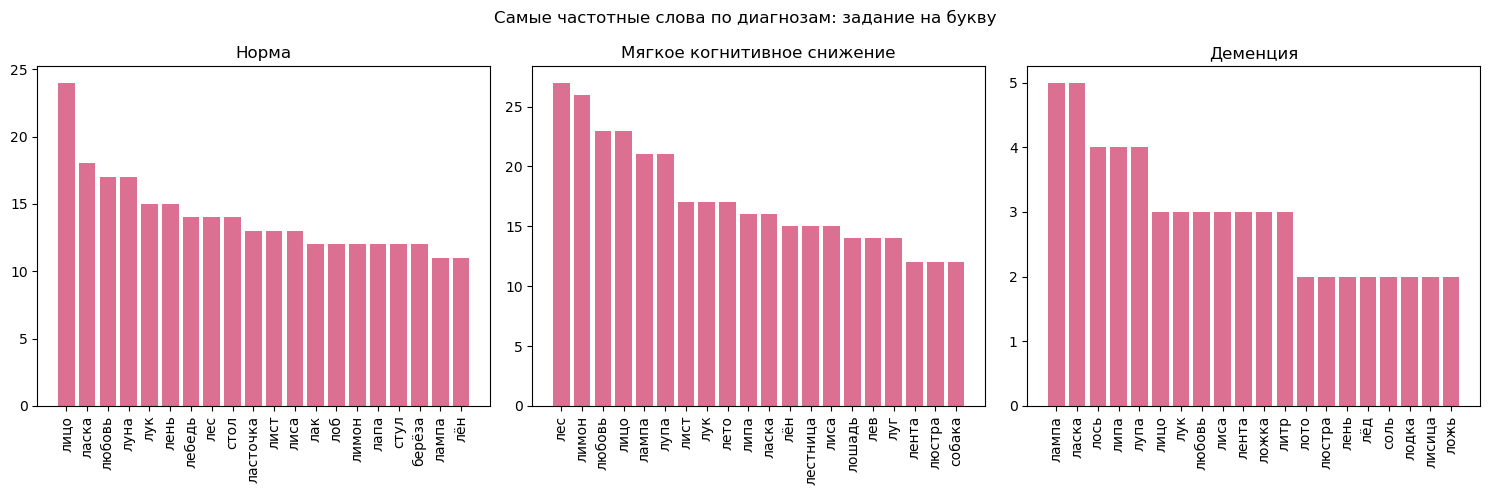

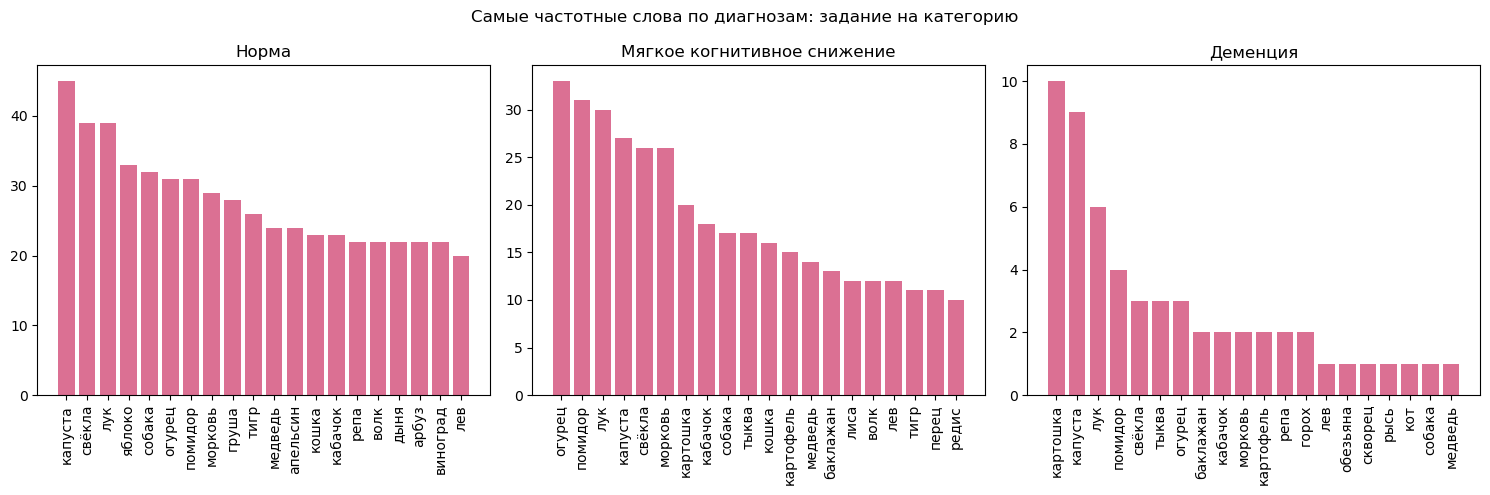

In [12]:
plot_freqdists('phonological')
plot_freqdists('semantic')

**Облака слов из самых популярных слов среди респондентов :)**

In [13]:
def wordlist(df): #отдельная функция, потому что список слов понадобится позже
    import matplotlib.pyplot as plt
    words = []
    for answer in (df['phonological']+ ', ' + df['semantic']): #одновременно считаем оба типа задания
        if answer == answer:
            for word in answer.split(', '):
                if word != '?':
                    word = morph.parse(word)[0].normal_form 
                    words.append(word)
    return words
#выводить облака слов для каждого диагноза сразу занимает много места, поэтому функция
def wordcloud(df, name):
    words = wordlist(df) #вложенная функция!
    from wordcloud import WordCloud
    from collections import Counter
    wordcloud = WordCloud(width = 1000,
                          height = 750,
                          background_color='black',
                          margin = 10,
                          colormap='RdPu').generate_from_frequencies(Counter(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'{name}: облако слов', fontsize=25, color="mediumvioletred")
    plt.show()

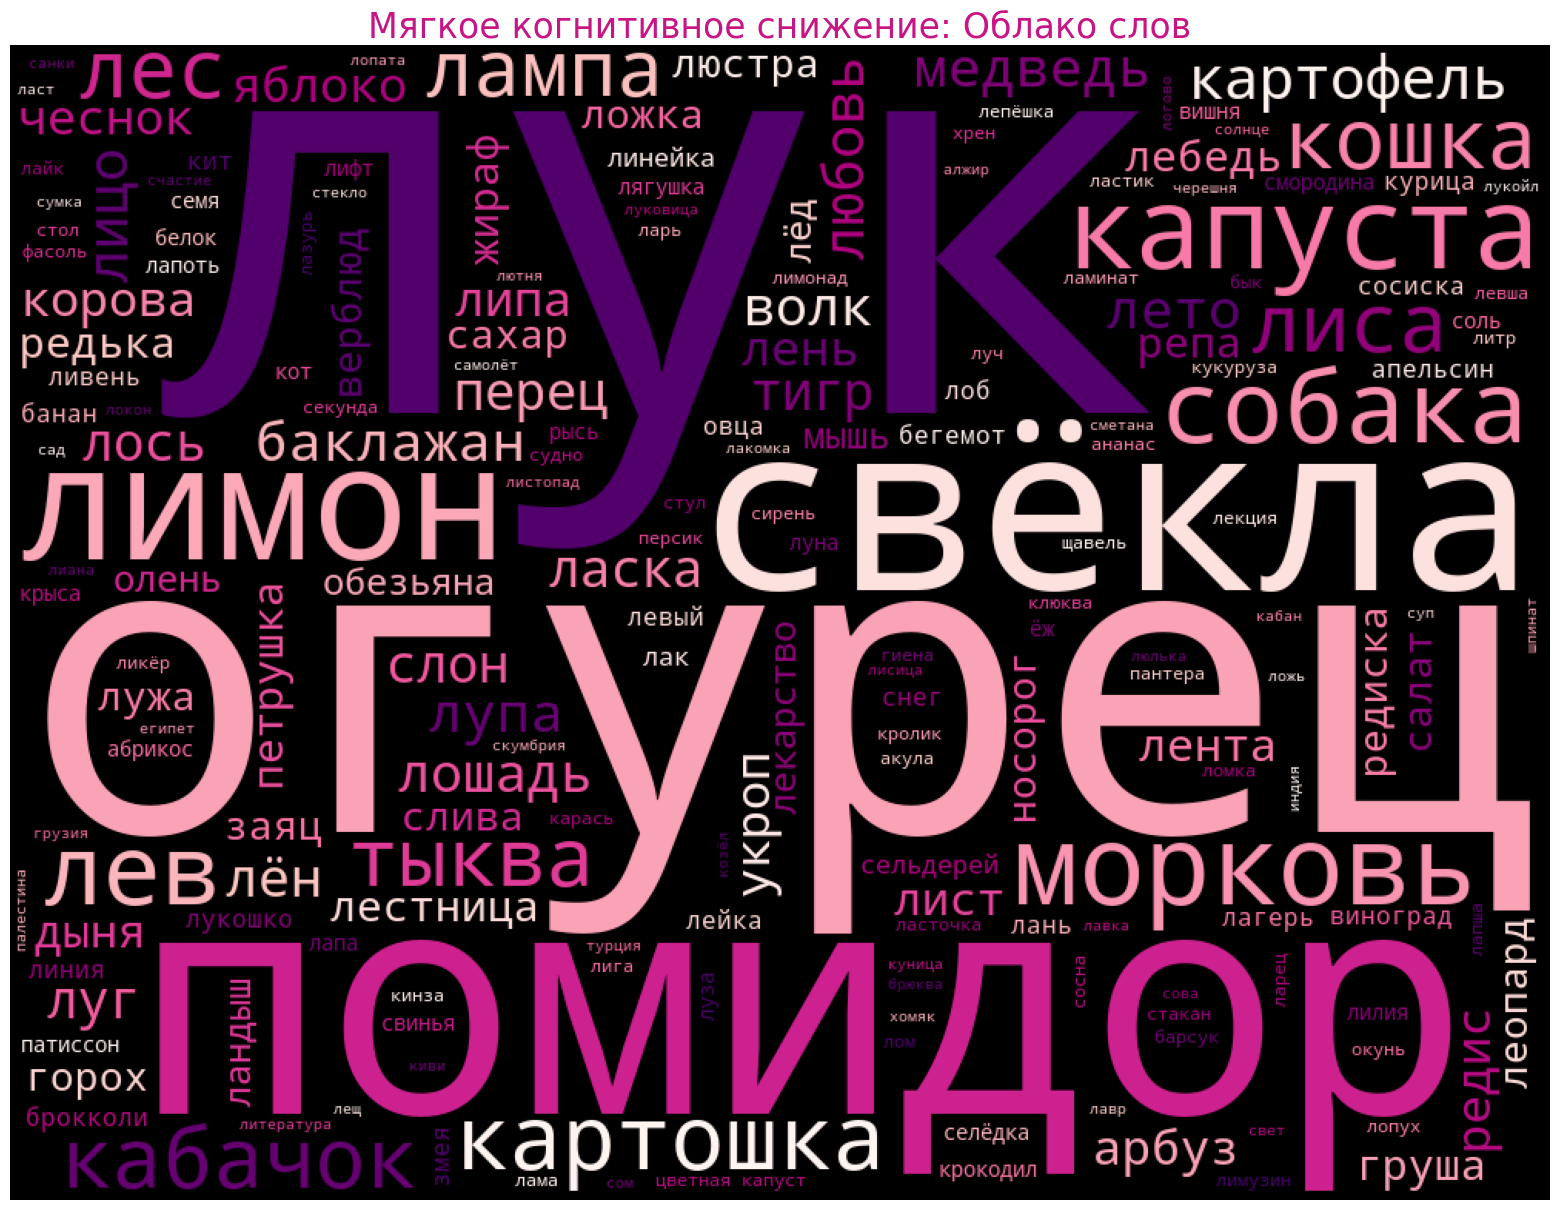

In [14]:
wordcloud(mci, 'Мягкое когнитивное снижение')

***Часть 5. Не частотности***


**Dice**

Тут поможет список слов, который возвращала предыдущая функция. Превратим списки во множества и посчитаем эту меру

In [15]:
set_norm = set(wordlist(norm))
set_mci = set(wordlist(mci))
set_dem = set(wordlist(dem))
set_all = set(wordlist(df))

*"the Dice score is equal to twice the size of the intersection divided by the sum of the sizes of the two sets. This means that the Dice score measures the proportion of overlap between the two sets, normalized by the size of the sets"*

In [16]:
print(f'Dice для нормы и МКС: {round(2*len(set_norm & set_mci)/(len(set_norm)+len(set_mci))*100,2)}%')
print(f'Dice для нормы и деменции: {round(2*len(set_norm & set_dem)/(len(set_norm)+len(set_dem))*100,2)}%')
print(f'Dice для МКС и деменции: {round(2*len(set_mci & set_dem)/(len(set_mci)+len(set_dem))*100,2)}%')

Dice для нормы и МКС: 44.04%
Dice для нормы и деменции: 19.39%
Dice для МКС и деменции: 25.93%


Получается, у нормы и МКС совпадают 44% названных слов, у нормы и деменции – 19%, у МКС и деменции – 26%. Получается, чем дальше прогрессирует снижение когнитивных функций, тем сильнее разница между здоровым и больным пациентом: у МКС почти в 2 раза больше пересечений с нормой

**Средняя длина слов**

In [17]:
def get_lengths(dataset):
    lengths_average = [] #список средних длин слов по каждому ответу
    for answer in (dataset['phonological']+ ', ' + dataset['semantic']): #одновременно считаем оба типа задания
        if answer == answer:
            leng_answer = [] #средняя длина слова в одном ответе
            for word in answer.split(', '):
                leng_answer.append(len(word)) #добавляем длину каждого слова в список
            lengths_average.append(statistics.fmean(leng_answer))
    meanleng = statistics.fmean(lengths_average) #среднее от всех средних длин :)
    return round(meanleng, 2)

In [18]:
print(f'Средняя длина слова по всему датасету: {get_lengths(df)}')
print(f'Средняя длина слова у нормы: {get_lengths(norm)}')
print(f'Средняя длина слова у МКС: {get_lengths(mci)}')
print(f'Средняя длина слова у пациентов с деменцией: {get_lengths(dem)}')

Средняя длина слова по всему датасету: 5.69
Средняя длина слова у нормы: 5.74
Средняя длина слова у МКС: 5.64
Средняя длина слова у пациентов с деменцией: 5.45


Здесь особо разницы нет

**Морфология**

In [19]:
from collections import Counter
def morphology(dataset):
    genders = [] #не включаю часть речи, потому что все слова – существительные по инструкции задания; все участники называли слова в именительном падеже
    animacies = [] 
    numbers = []
    for answer in (dataset['phonological']+ ', ' + dataset['semantic']): #одновременно считаем оба типа задания
        if answer == answer:
            for word in answer.split(', '):
                genders.append(morph.parse(word)[0].tag.gender)
                animacies.append(morph.parse(word)[0].tag.animacy)
                numbers.append(morph.parse(word)[0].tag.number)
    return Counter(genders), Counter(animacies), Counter(numbers)

In [20]:
#просто передаём список из результатов функции, разделив по подкатегориям
all_list = [morphology(df)[0]['femn'],morphology(df)[0]['masc'],morphology(df)[0]['neut'],morphology(df)[1]['anim'],morphology(df)[1]['inan'],morphology(df)[2]['sing'],morphology(df)[2]['plur']]
norm_list = [morphology(norm)[0]['femn'],morphology(norm)[0]['masc'],morphology(norm)[0]['neut'],morphology(norm)[1]['anim'],morphology(norm)[1]['inan'],morphology(norm)[2]['sing'],morphology(norm)[2]['plur']]
mci_list = [morphology(mci)[0]['femn'],morphology(mci)[0]['masc'],morphology(mci)[0]['neut'],morphology(mci)[1]['anim'],morphology(mci)[1]['inan'],morphology(mci)[2]['sing'],morphology(mci)[2]['plur']]
dem_list = [morphology(dem)[0]['femn'],morphology(dem)[0]['masc'],morphology(dem)[0]['neut'],morphology(dem)[1]['anim'],morphology(dem)[1]['inan'],morphology(dem)[2]['sing'],morphology(dem)[2]['plur']]

In [21]:
#собираем из списков датафрейм
morphodata = pd.DataFrame([norm_list, mci_list, dem_list, all_list])
multicolumns = [('Род','Женский'),('Род','Мужской'),('Род','Средний'),('Одушевлённость','Одушевлённые'),('Одушевлённость','Неодушевлённые'),('Число','Единственное'),('Число','Множественное')]
rows = [('Здоровые'),('МКС'),('Деменция'), ('Все')]
col_list = pd.MultiIndex.from_tuples(multicolumns)
morphodata = pd.DataFrame([norm_list, mci_list, dem_list, all_list], index=rows, columns=col_list)
morphodata

Род                 Одушевлённость                       Число  \
         Женский Мужской Средний   Одушевлённые Неодушевлённые Единственное   
Здоровые    1387    1636     200            985           2226         3101   
МКС          736     873     101            509           1204         1696   
Деменция     104      97       9             50            159          209   
Все         2227    2606     310           1544           3589         5006   

                        
         Множественное  
Здоровые           160  
МКС                 33  
Деменция             2  
Все                195

Для большей репрезентативности добавляем значения в процентах (где 100% – это сумма существительных любого рода/одушевлённости/числа для каждого конкретного диагноза)

In [22]:
morphodata_pct = morphodata.copy() #пока отдельный датасет только с процентами
for category in ["Род", "Одушевлённость", "Число"]: #итерируемся по колонкам, входящим в одну из этих категорий
    morphodata_pct[category] = morphodata[category].div(morphodata[category].sum(axis=1), axis=0) * 100 #считаем сумму внутри этой категории, div делит каждый элемент в строке на получившуюся сумму, переводим в проценты
morphodata_pct

Род                      Одушевлённость                 \
            Женский    Мужской   Средний   Одушевлённые Неодушевлённые   
Здоровые  43.034440  50.760161  6.205399      30.675802      69.324198   
МКС       43.040936  51.052632  5.906433      29.713952      70.286048   
Деменция  49.523810  46.190476  4.285714      23.923445      76.076555   
Все       43.301575  50.670815  6.027610      30.079875      69.920125   

                Число                
         Единственное Множественное  
Здоровые    95.093530      4.906470  
МКС         98.091382      1.908618  
Деменция    99.052133      0.947867  
Все         96.250721      3.749279

In [23]:
#добавляем к изначальному датасету
morphodata = morphodata.astype(str) + " (" + morphodata_pct.round(2).astype(str) + "%)" #чтобы соединить со скобками и знаком процента, пришлось перевести числа в строки
morphodata

Род                             Одушевлённость  \
                Женский        Мужской      Средний   Одушевлённые   
Здоровые  1387 (43.03%)  1636 (50.76%)  200 (6.21%)   985 (30.68%)   
МКС        736 (43.04%)   873 (51.05%)  101 (5.91%)   509 (29.71%)   
Деменция   104 (49.52%)    97 (46.19%)    9 (4.29%)    50 (23.92%)   
Все        2227 (43.3%)  2606 (50.67%)  310 (6.03%)  1544 (30.08%)   

                                 Число                
         Неодушевлённые   Единственное Множественное  
Здоровые  2226 (69.32%)  3101 (95.09%)   160 (4.91%)  
МКС       1204 (70.29%)  1696 (98.09%)    33 (1.91%)  
Деменция   159 (76.08%)   209 (99.05%)     2 (0.95%)  
Все       3589 (69.92%)  5006 (96.25%)   195 (3.75%)

Особо никаких различий нет: пациенты с деменцией немного чаще называют слова женского рода (на 6% больше), неодушевлённые (тоже на 6% больше), и единственного числа. Но разница совсем незначительная и может объясняться тем, что в датасете намного меньше пациентов с деменцией